### Necessary Import

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

%matplotlib inline

2024-04-23 22:59:29.473181: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 22:59:29.536389: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 22:59:29.536425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 22:59:29.538218: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 22:59:29.546656: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 22:59:29.547516: I tensorflow/core/platform/cpu_feature_guard.cc:1

### Dataset

In [2]:
DB_DIR = '../Datasets/DRIVE/'

### Input Pipeline

In [3]:
train_image_paths = sorted(glob.glob(DB_DIR + 'training/images/*'))
train_mask_paths = sorted(glob.glob(DB_DIR + 'training/mask/*'))
test_image_paths = sorted(glob.glob(DB_DIR + 'test/images/*'))
test_mask_paths = sorted(glob.glob(DB_DIR + 'test/mask/*'))

In [4]:
def show_image(image, mask):
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title('Image')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.show()

In [5]:
def load_image(img_path, size=(256, 256), isImage = True):
    
    if type(img_path) is bytes:
        img_path = img_path.decode("utf-8")
    
    if isImage:
        img = cv2.imread(img_path)
        img = cv2.resize(img,size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    else:
        gif_mask = cv2.VideoCapture(img_path)

        frames = []
        while True:
            ret, frame = gif_mask.read()
            if not ret:
                break
            frames.append(frame)
        
        gif_mask.release()
        img = frames[0][:, :, 0]
        img = cv2.resize(img,size)
        img = np.expand_dims(img, -1)

    img = img/255
    return img.astype(np.float32)

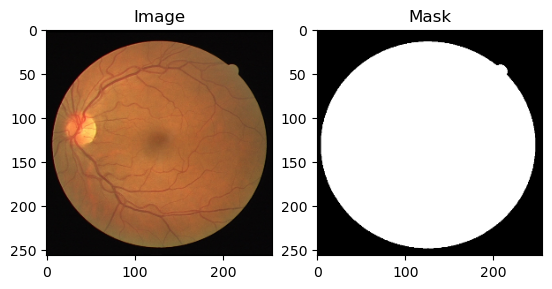

In [6]:
image = load_image(test_image_paths[0], (256,256), True)
mask = load_image(train_mask_paths[0], (256,256), False)

show_image(image, mask)

In [7]:
def create_dataset(image_paths, mask_paths):
    images_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    masks_ds = tf.data.Dataset.from_tensor_slices(mask_paths)
    
    # Create Dataset Object
    dataset = tf.data.Dataset.zip(images_ds, masks_ds)
    dataset = dataset.shuffle(100000, seed=21)
    
    # Load Images
    dataset = dataset.map(lambda x,y:(tf.numpy_function(load_image, [x, (256, 256), True], [tf.float32]), tf.numpy_function(load_image, [y, (256, 256), False], [tf.float32],)), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(lambda x,y: (tf.reshape(x, (256,256,3)), tf.reshape(y, (256,256,1))),  num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(16)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset
    

In [8]:
train_ds = create_dataset(train_image_paths, train_mask_paths)
test_ds = create_dataset(test_image_paths, test_mask_paths)

### Model

In [9]:
def conv2d_downsampling(x, filters):
    x = keras.layers.Conv2D(filters=filters, kernel_size=3, strides=2, padding='same')(x)
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = keras.layers.Activation('relu')(x)
    
    return x

In [10]:
def conv2d_upsampling(x, filters):
    x = keras.layers.Conv2DTranspose(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2DTranspose(filters=filters, kernel_size=3, strides=2, padding='same')(x)
    x = keras.layers.Activation('relu')(x)
    
    return x

In [11]:
input = keras.Input(shape=(256, 256, 3))

x = conv2d_downsampling(input, 64)
x = conv2d_downsampling(x, 128)
x = conv2d_downsampling(x, 256)

x = conv2d_upsampling(x, 256)
x = conv2d_upsampling(x, 128)
x = conv2d_upsampling(x, 64)

output = keras.layers.Conv2D(filters=2, kernel_size=1, strides=1, padding='same', activation='relu')(x)

model = keras.Model(input, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 activation_2 (Activation)   (None, 64, 64, 128)       0     

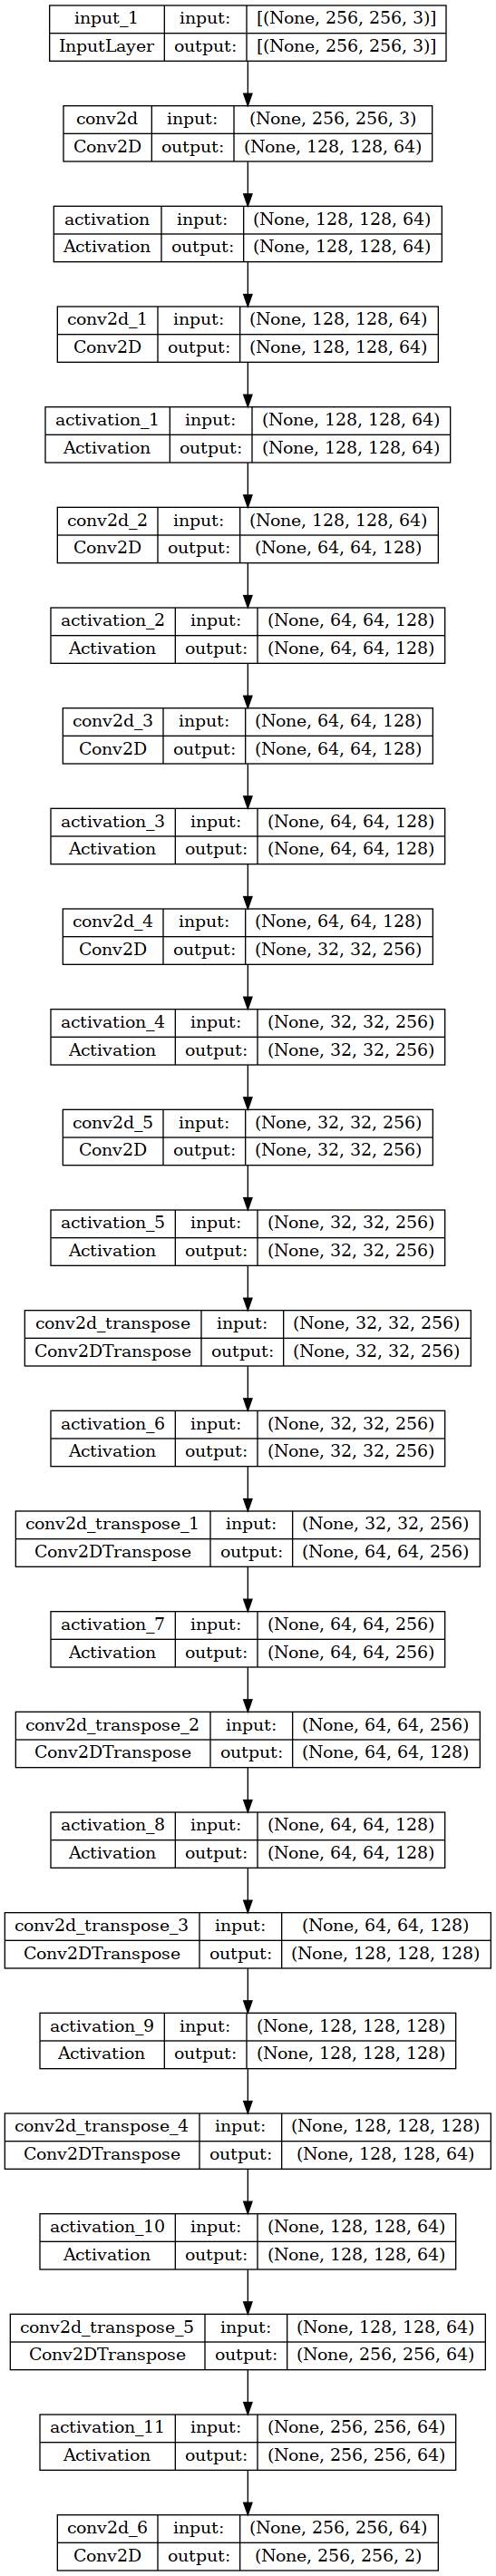

In [12]:
keras.utils.plot_model(model, show_shapes=True)

In [13]:
model.compile(optimizer=keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.MeanIoU(num_classes=2, sparse_y_pred=False)]) 

In [14]:
class PlotCallback(keras.callbacks.Callback):
    def __init__(self, val_batch, figpath, num_classes, preprocess_fn=None, count=3):
        super().__init__()
        self.min_loss = 100000
        self.figpath = figpath
        self.val_batch = val_batch
        self.count = count
        self.num_classes = num_classes
        self.preprocess_fn = preprocess_fn
        
        
    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')
        
        if current_loss < self.min_loss:
            self.min_loss = current_loss
            figpath = f'{self.figpath}/best_{epoch+1}.png'
            self.plot(figpath)
        return
    
    
    def plot(self, fig_path):
        for batch in self.val_batch.take(1):
            image = batch[0]
            mask = batch[1]
            
            # preds = self.model(self.preprocess_fn(image))
            preds = self.model(image) # No Pre-process
            preds = tf.argmax(preds, axis=-1)
            preds = tf.cast(preds, tf.uint8)
            
            
            plt.figure(figsize=(30, 16))
            for i in range(self.count):
                plt.subplot(3,self.count,i+1)
                plt.imshow(image[i])
                plt.title('image')
                plt.axis('off')
                
                plt.subplot(3,self.count,i+self.count+1)
                plt.imshow(mask[i], cmap='gray', vmin=0, vmax=self.num_classes-1)
                plt.axis('off')
                plt.title('mask')
                
                plt.subplot(3,self.count,i+2*self.count+1)
                plt.imshow(preds[i], cmap='gray', vmin=0, vmax=self.num_classes-1)
                plt.axis('off')
                plt.title('prediction')
            
            plt.tight_layout(h_pad=1, w_pad=1)
            plt.savefig(fig_path)
            plt.close()

In [15]:
plot_callback = PlotCallback(
        test_ds.take(1),
        figpath= './Saved_Figures/',
        count=3,
        num_classes=2,
    )

bnr_callback = keras.callbacks.BackupAndRestore(
        backup_dir='./BackupAndRestore/',
        delete_checkpoint=False  
    )

# lr_callback = keras.callbacks.ReduceLROnPlateau(
#         factor=0.8,
#         min_lr=1e-7,
#         patience = int(5 / 2.5),
#         cooldown=5
#     )

es_callback = keras.callbacks.EarlyStopping(
        patience=5,
        start_from_epoch=50,
        verbose=1,
        restore_best_weights=True,
        monitor='val_loss'
    )
    
    
my_callbacks = [
    plot_callback, 
    bnr_callback,
    # lr_callback,
    es_callback,
]

In [16]:
history = model.fit(
    train_ds,
    epochs = 150, 
    validation_data = test_ds,
    callbacks=my_callbacks,
    )

Epoch 1/150


2024-04-23 22:59:41.867225: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2024-04-23 22:59:42.742007: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


2/2 [==============================] - ETA: 0s - loss: 3.0066 - mean_io_u: 0.2584 

2024-04-23 22:59:56.286831: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2024-04-23 23:00:01.925203: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2024-04-23 23:00:02.359839: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


2/2 [==============================] - 30s 16s/step - loss: 3.0066 - mean_io_u: 0.2584 - val_loss: 1.3834 - val_mean_io_u: 0.3130
Epoch 2/150
2/2 [==============================] - 23s 14s/step - loss: 1.3601 - mean_io_u: 0.3162 - val_loss: 0.9735 - val_mean_io_u: 0.3343
Epoch 3/150
2/2 [==============================] - 23s 13s/step - loss: 0.9602 - mean_io_u: 0.3333 - val_loss: 0.6178 - val_mean_io_u: 0.3422
Epoch 4/150
2/2 [==============================] - 23s 13s/step - loss: 0.6177 - mean_io_u: 0.3424 - val_loss: 0.6170 - val_mean_io_u: 0.3422
Epoch 5/150
2/2 [==============================] - 22s 13s/step - loss: 0.6152 - mean_io_u: 0.3424 - val_loss: 0.5964 - val_mean_io_u: 0.3406
Epoch 6/150
2/2 [==============================] - 27s 18s/step - loss: 0.5965 - mean_io_u: 0.3404 - val_loss: 0.5910 - val_mean_io_u: 0.3412
Epoch 7/150
2/2 [==============================] - 22s 13s/step - loss: 0.5874 - mean_io_u: 0.3416 - val_loss: 0.5723 - val_mean_io_u: 0.3422
Epoch 8/150
2/2 [=

In [17]:
print(history.history)

{'loss': [3.0066351890563965, 1.3601444959640503, 0.9602206945419312, 0.6177117228507996, 0.6152014136314392, 0.5964625477790833, 0.587420642375946, 0.5704840421676636, 0.5521111488342285, 0.5257747769355774, 0.4958898425102234, 0.46274009346961975, 0.42397618293762207, 0.38312044739723206, 0.347234308719635, 0.31674495339393616, 0.29138416051864624, 0.27256444096565247, 0.26669710874557495, 0.24982020258903503, 0.2617380619049072, 0.26272469758987427, 0.2498430758714676, 0.24341019988059998, 0.22862891852855682, 0.2972683012485504, 0.38492265343666077, 0.2675427496433258, 0.2696850299835205, 0.2788534164428711, 0.23076865077018738, 0.18158674240112305, 0.15078255534172058, 0.16516384482383728, 0.15782530605793, 0.13935969769954681, 0.14231522381305695, 0.09847211837768555, 0.08507232367992401, 0.08101407438516617, 0.08098214119672775, 0.060317397117614746, 0.06336960196495056, 0.049889691174030304, 0.0379914715886116, 0.03824828937649727, 0.03902694582939148, 0.220075324177742, 0.1721

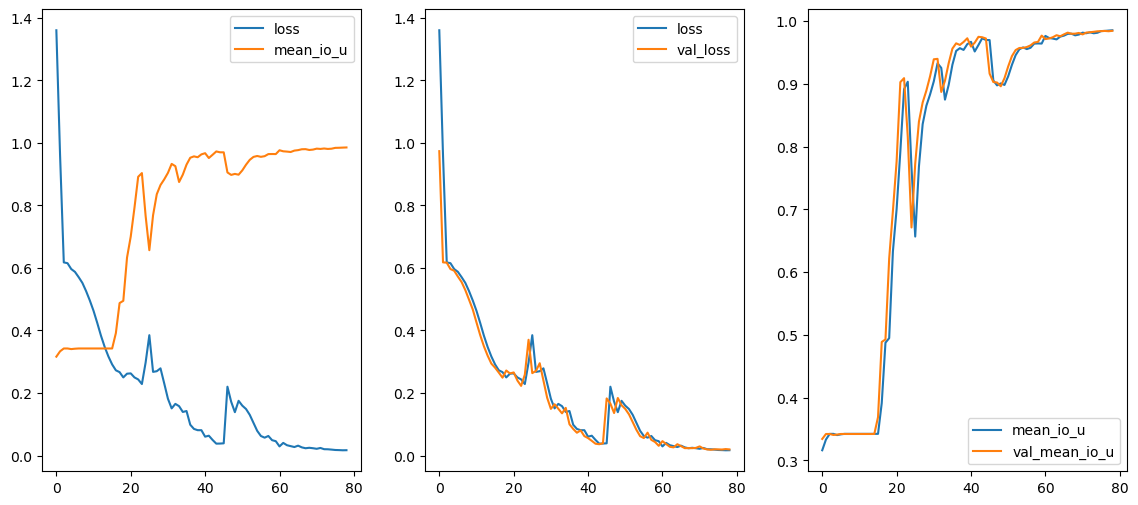

In [18]:
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['mean_io_u'][1:])
plt.legend(["loss", "mean_io_u"])

plt.subplot(1,3,2)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.legend(["loss", "val_loss"])

plt.subplot(1,3,3)
plt.plot(history.history['mean_io_u'][1:])
plt.plot(history.history['val_mean_io_u'][1:])
plt.legend(["mean_io_u", "val_mean_io_u"])